In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import find_peaks, savgol_filter, peak_widths

In [84]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/HAR_transition/data/MHEALTHDATASET/'

In [85]:
FS = 50                  # Hz
CRUNCH_WIN_SEC = 1.5     # 동작 하나가 1초보다 길 수도 있어서 여유 있게
MIN_DISTANCE_SEC = 2   # 한 동작 하고 다음 동작까지 최소 1.2초는 걸린다고 가정 (중복 방지)
PROMINENCE_SCALE = 0.5   # 피크 감지 민감도 (높을수록 큰 피크만 잡음)
SMOOTH_WINDOW = 51

In [86]:
def load_mhealth_logs(data_dir):
    """
    mHealth_subject1.log ~ subject10.log 파일을 읽어서 하나로 합치는 함수.
    """
    # mHealth 데이터셋의 공식 컬럼 구조 (23개 컬럼 + 라벨)
    # 인덱스 기준:
    # 0-2: Chest Acc
    # 3-4: ECG (2개)
    # 5-7: Left Ankle Acc (alx, aly, alz)
    # 8-10: Left Ankle Gyro (glx, gly, glz)
    # 11-13: Left Ankle Mag
    # 14-16: Right Lower Arm Acc (arx, ary, arz)
    # 17-19: Right Lower Arm Gyro (grx, gry, grz)
    # 20-22: Right Lower Arm Mag
    # 23: Activity Label

    column_names = [
        'acx', 'acy', 'acz',          # Chest Acc
        'ecg1', 'ecg2',               # ECG
        'alx', 'aly', 'alz',          # Left Ankle Acc
        'glx', 'gly', 'glz',          # Left Ankle Gyro
        'mlx', 'mly', 'mlz',          # Left Ankle Mag
        'arx', 'ary', 'arz',          # Right Arm Acc
        'grx', 'gry', 'grz',          # Right Arm Gyro
        'mrx', 'mry', 'mrz',          # Right Arm Mag
        'Activity'                    # Label
    ]

    all_data = []

    print(f"'{data_dir}' 폴더에서 파일을 찾는 중...")

    # Subject 1부터 10까지 루프
    for subject_id in range(1, 11):
        file_name = f"mHealth_subject{subject_id}.log"
        file_path = os.path.join(data_dir, file_name)

        if not os.path.exists(file_path):
            print(f"경고: {file_name} 파일 없음.")
            continue

        try:
            # 로그 파일 읽기 (공백으로 구분)
            df = pd.read_csv(file_path, header=None, sep='\s+')

            # 컬럼 개수 확인
            if df.shape[1] != 24:
                print(f"{file_name} 컬럼 개수 이상. ({df.shape[1]}개). 체크 필요")
                continue

            # 컬럼명 할당
            df.columns = column_names

            # Subject ID 컬럼 추가
            df['subject'] = subject_id

            all_data.append(df)
            print(f"Loaded: Subject {subject_id} ({len(df)} samples)")

        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    if not all_data:
        print("데이터 로딩 실패")
        return None

    # 하나로 합치기
    final_df = pd.concat(all_data, ignore_index=True)
    print(f"총 {len(final_df)} 샘플 로딩 완료")

    return final_df

<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4260380323.py:44: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, header=None, sep='\s+')


In [87]:
def detect_peaks_smart(subject_data, fs=FS):
    """
    단일 축 대신 Magnitude(벡터 합)를 사용하고,
    Savgol 필터로 신호를 부드럽게 만들어서 자잘한 노이즈를 없애는 함수
    """
    # 1. Magnitude 계산 (x^2 + y^2 + z^2 의 제곱근) -> 방향 상관없이 움직임의 '크기'만 봄
    # 가속도(Accel) 데이터를 쓰는 게 동작 횟수 세기엔 더 유리할 때가 많음 (중력 가속도 변화 때문)
    acc_mag = np.sqrt(subject_data['alx']**2 + subject_data['aly']**2 + subject_data['alz']**2)

    # 2. 스무딩 (Smoothing) - 거친 신호를 부드럽게 다듬음 (window_length는 홀수여야 함)
    # 50Hz * 0.5초 = 25 샘플 정도로 부드럽게 뭉개줌
    smooth_signal = savgol_filter(acc_mag, window_length=SMOOTH_WINDOW, polyorder=3)

    # 3. 피크 검출 설정
    distance = int(MIN_DISTANCE_SEC * fs)
    prominence = PROMINENCE_SCALE * np.std(smooth_signal)

    # 4. 피크 찾기
    peaks, properties = find_peaks(smooth_signal, distance=distance, prominence=prominence)

    return peaks, smooth_signal

In [95]:
def plot_crunch_detection(df, activity_code):
    """
    각 피험자별로 20회가 잘 잡히는지 확인하는 플롯
    """
    act_df = df[df['Activity'] == activity_code].copy()
    subjects = act_df['subject'].unique()

    fig, axes = plt.subplots(len(subjects), 1, figsize=(12, 4 * len(subjects)), sharex=False)
    if len(subjects) == 1: axes = [axes] # 피험자가 1명이면 리스트로 변환

    print(f"Activity {activity_code} 분석 시작...")

    for i, sub in enumerate(subjects):
        sub_data = act_df[act_df['subject'] == sub].reset_index(drop=True)

        # 피크 검출
        peaks, smooth_sig = detect_peaks_smart(sub_data)
        num_peaks = len(peaks)

        # 시각화
        ax = axes[i]
        ax.plot(sub_data.index, smooth_sig, label='Smoothed Accel Magnitude', color='black', alpha=0.7)
        ax.plot(peaks, smooth_sig[peaks], "x", color='red', markersize=10, label='Detected Peak')

        # 상태 메시지
        title_color = 'green' if 18 <= num_peaks <= 22 else 'red'

        ax.set_title(f"Subject {sub}: Detected {num_peaks} peaks", color=title_color, fontweight='bold')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()

    plt.tight_layout()
    plt.show()

In [89]:
def detect_crunch_segments(subject_data, fs=50):
    # 1. 신호 처리 (Magnitude & Smoothing)
    acc_mag = np.sqrt(subject_data['alx']**2 + subject_data['aly']**2 + subject_data['alz']**2)
    smooth_signal = savgol_filter(acc_mag, window_length=SMOOTH_WINDOW, polyorder=3)

    # 2. 피크 찾기
    distance = int(MIN_DISTANCE_SEC * fs)
    prominence = PROMINENCE_SCALE * np.std(smooth_signal)
    peaks, _ = find_peaks(smooth_signal, distance=distance, prominence=prominence)

    # 3. 피크 너비(Width)를 이용해 시작(Start)과 끝(End) 구하기
    # rel_height=0.6 : 피크 높이의 60% 지점에서 너비를 구함 (이걸로 구간 정의)
    results_half = peak_widths(smooth_signal, peaks, rel_height=0.6)

    # results_half[2]는 시작점들의 실수(float) 인덱스, [3]은 끝점들
    start_indices = np.floor(results_half[2]).astype(int)
    end_indices = np.ceil(results_half[3]).astype(int)

    # 구간 리스트로 변환 [(start, end), (start, end)...]
    segments = list(zip(start_indices, end_indices))

    return peaks, smooth_signal, segments

In [90]:
def plot_segmentation_result(df, activity_code=8):
    act_df = df[df['Activity'] == activity_code].copy()
    subjects = act_df['subject'].unique()

    # 잘된 사람 3명, 안된 사람 1명 정도만 뽑아서 디테일하게
    # (여기서는 전체 다 그림)
    fig, axes = plt.subplots(len(subjects), 1, figsize=(12, 4 * len(subjects)), sharex=False)
    if len(subjects) == 1: axes = [axes]

    print(f"GT 구간(Segment) 추출 시작... (Width 기반)")

    for i, sub in enumerate(subjects):
        sub_data = act_df[act_df['subject'] == sub].reset_index(drop=True)

        # 구간 추출
        peaks, smooth_sig, segments = detect_crunch_segments(sub_data)

        ax = axes[i]
        # 원본 신호
        ax.plot(sub_data.index, smooth_sig, color='black', alpha=0.6, label='Signal')

        # 피크 표시
        ax.plot(peaks, smooth_sig[peaks], "x", color='red', markersize=10)

        # 추출된 구간을 박스로 그리기
        for (start, end) in segments:
            # 안전장치: 인덱스 범위 체크
            start = max(0, start)
            end = min(len(sub_data)-1, end)

            # 붉은색 박스로 "동작 중(Action)" 표시
            ax.axvspan(start, end, color='red', alpha=0.2)

            # 박스 앞뒤가 바로 "전이(Transition)" 구간

        ax.set_title(f"Subject {sub}: {len(segments)} Segments Detected (Red Area = Action)", fontweight='bold')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

'/content/drive/MyDrive/Colab Notebooks/HAR_transition/data/MHEALTHDATASET/' 폴더에서 파일을 찾는 중...
Loaded: Subject 1 (161280 samples)
Loaded: Subject 2 (130561 samples)
Loaded: Subject 3 (122112 samples)
Loaded: Subject 4 (116736 samples)
Loaded: Subject 5 (119808 samples)
Loaded: Subject 6 (98304 samples)
Loaded: Subject 7 (104448 samples)
Loaded: Subject 8 (129024 samples)
Loaded: Subject 9 (135168 samples)
Loaded: Subject 10 (98304 samples)
총 1215745 샘플 로딩 완료
Activity 8 분석 시작...


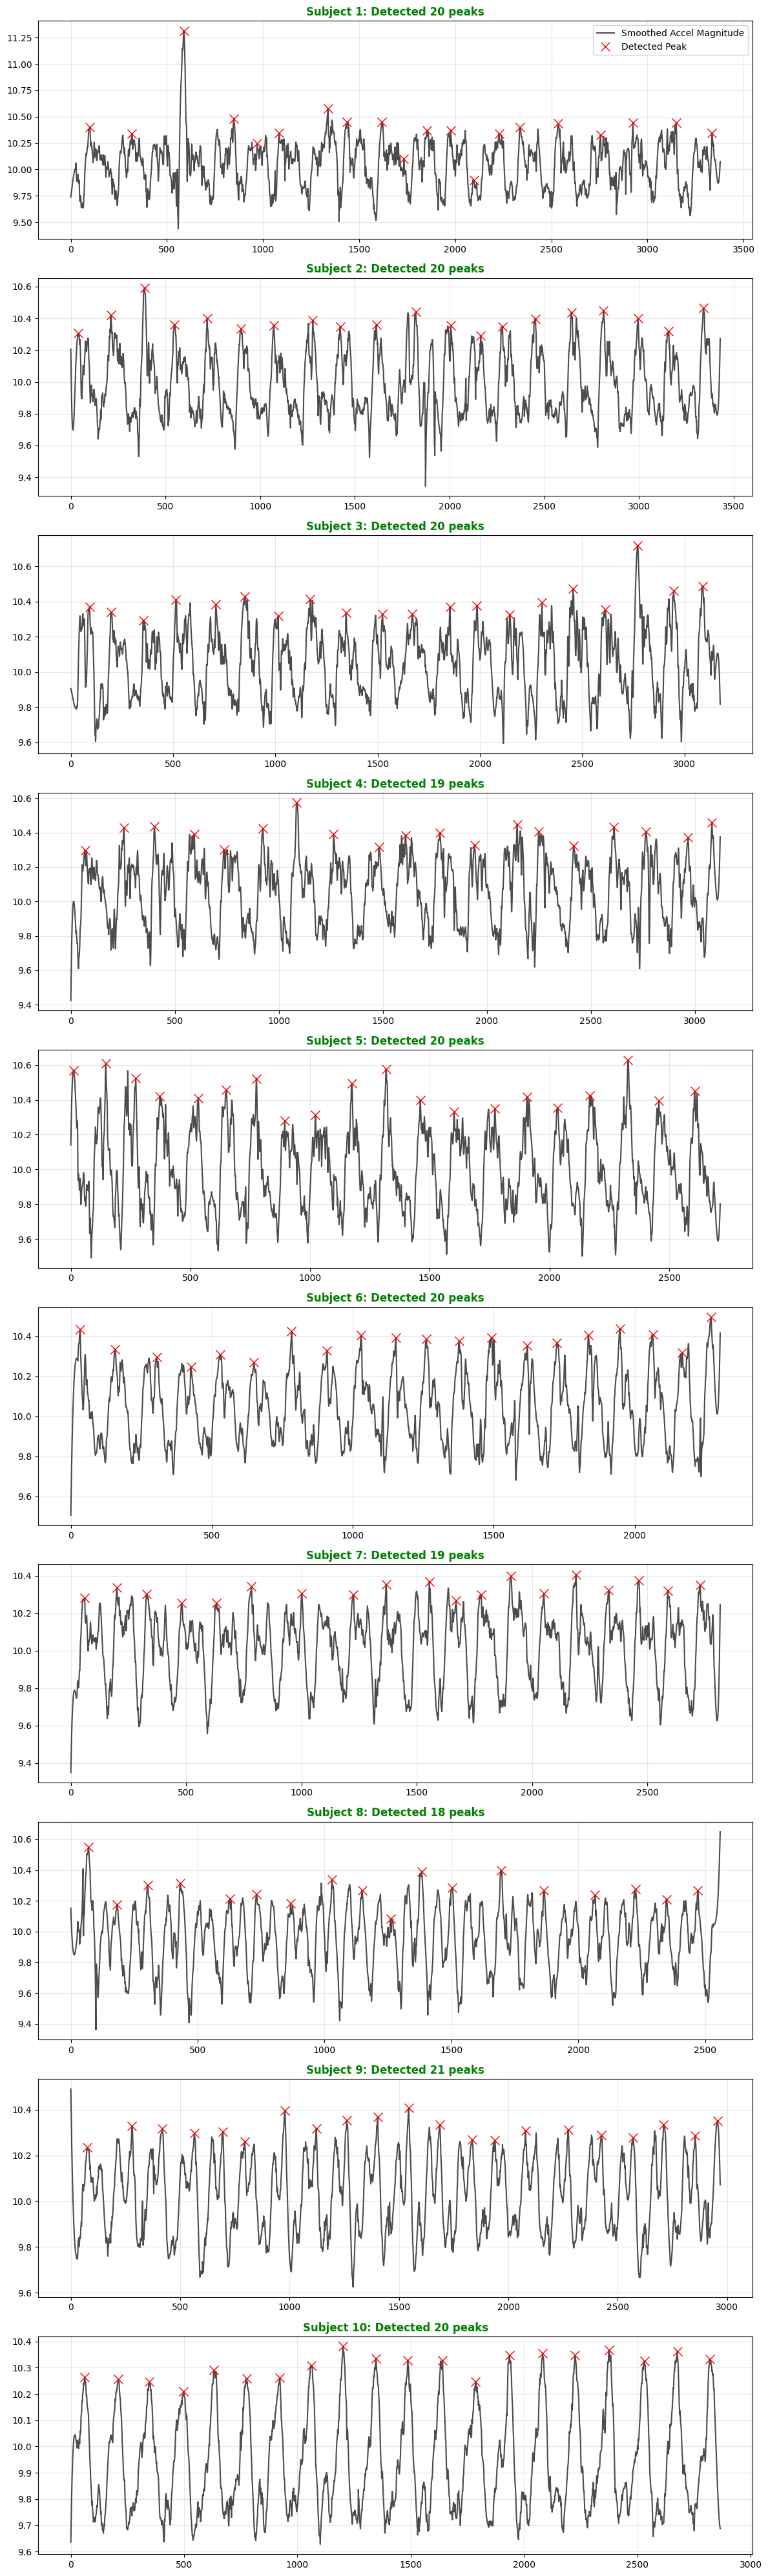

In [96]:
df = load_mhealth_logs(DATA_DIR)
plot_crunch_detection(df, activity_code=8)

GT 구간(Segment) 추출 시작... (Width 기반)


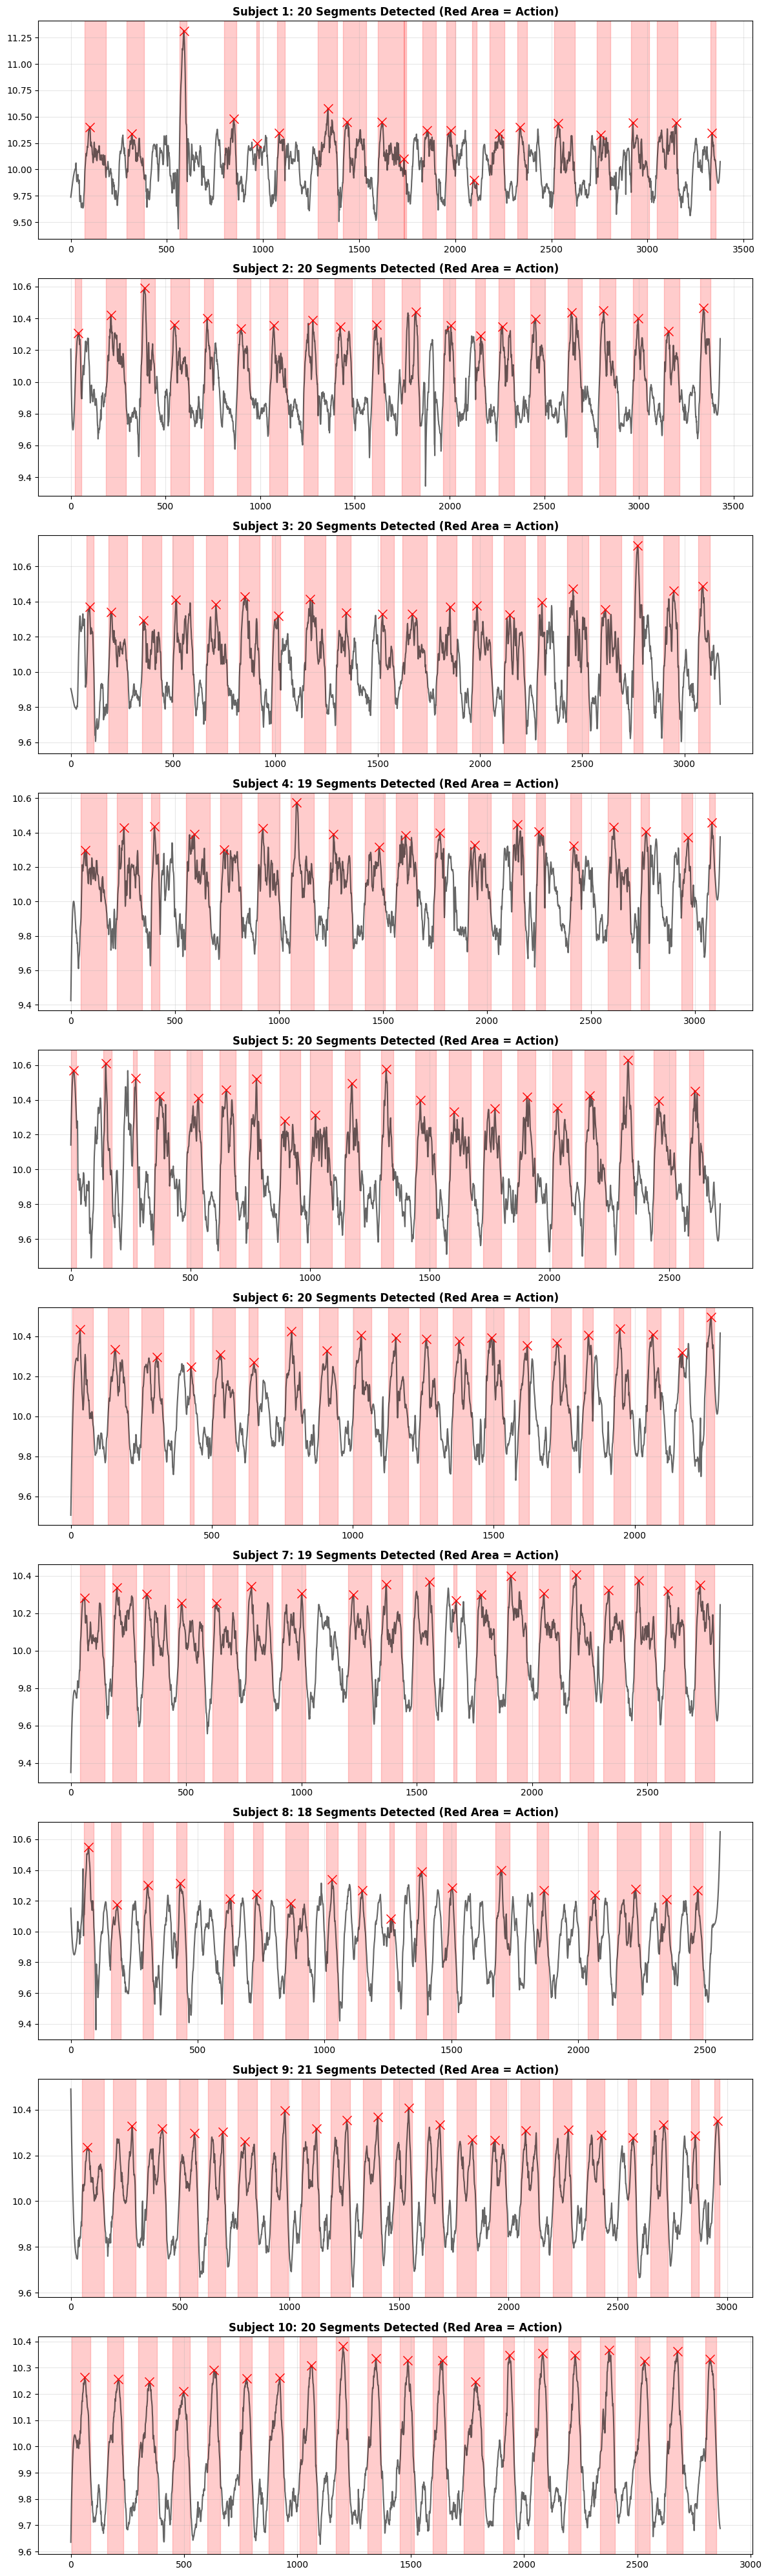

In [92]:
plot_segmentation_result(df, activity_code=8)